In [1]:
import os
import h5py
import pickle
import numpy as np
from math import log, floor
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm    # Progress Bar
from prettytable import PrettyTable       # Tabulate results. Install it by running pip install PrettyTable

In [3]:
def formatting_numbers(num): 
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    value = int(floor(log(num, k)))
    return '%.2f%s' % (num / k**value, units[value])

def extract_data(fname):
    """
    This function reads the objects from the hdf5 file and 
    returns a dictionary object 
    Args:- fname (string): File name 
    Returns:- dictionary: object with keys and values of objects from file
    """
    data = {}
    with h5py.File(fname, 'r') as hf:
        values = [np.array(val) for val in hf.values()]     # Convert hdf5 data to numpy array
        data = dict(zip(hf.keys(),values))                  # Add the data to a dictionary 
    return data

## 1. Activation Layer
- The operations performed by activation layer are defined in this class
- Supports tanh, relu and softmax activation
- The gradient of these activation functions applied during backward pass are also defined here

In [4]:
class ActivationLayer(object):

    def __init__(self,name,activation_type):
        
        self.name = name
        self.activation_type = activation_type

        supported_activations = ['softmax','tanh','relu']

        if self.activation_type not in supported_activations:
            raise ValueError('Activation Function {} not supported'
        .format(self.activation_function))
        
    def activation_function(self,input_val):

        if self.activation_type=='relu':
            return np.maximum(0,input_val)

        # Clipping input to avoid 'nan's on overflow or underflow
        input_val = np.clip( input_val, -500, 500 )

        if self.activation_type=='tanh':
            return (np.exp(2*input_val) -1 ) / (np.exp(2*input_val)+1)
        elif self.activation_type=='softmax':
            return np.exp(input_val) / np.exp(input_val).sum(axis=0)
    
    def gradient_activation_function(self,input_val):

        output_val = np.copy(input_val)
        
        if self.activation_type=='relu':
            #Heaviside function
            output_val[input_val>0] = 1
            output_val[input_val<0] = 0
            output_val[input_val==0] = 0.5  
            return output_val
        elif self.activation_type=='tanh':
            return 1-np.power( self.activation_function(output_val),2)
    
    def forward(self, input):
        return self.activation_function(input)
    
    def backward(self,prev_pre_activation_gradients, previous_weights):
        return  np.dot(previous_weights.T , prev_pre_activation_gradients)


## 2. Pre Activation Layer
- Supports multiple initializations type for the weights: uniform, glorot, he_normal, he_uniform
- Cache the gradient of the weights , biases and of its pre activation
- Contains functions to make forward and backward pass

In [5]:
class PreActivationLayer(object):
    
    def __init__(self,name,dimensions,initialization_type='glorot'):
        
        self.name = name
        self.dimensions = dimensions 
        self.weights = None
        self.bias = None 
        self.dw = None
        self.db = None
        self.d_preactivation = None
        self.initialize_weigths(initialization_type)

    def initialize_weigths(self,initialization_type):

        self.bias = np.zeros((self.dimensions[0],1))
        if initialization_type =='normal':
            self.weights = np.random.normal(0,1,self.dimensions)
        elif initialization_type =='glorot':
            uniform_range = np.sqrt(6) / np.sqrt(np.sum(self.dimensions))
            self.weights = np.random.uniform(-1 * uniform_range, \
                uniform_range ,self.dimensions)
        elif initialization_type =='he_uniform':
            uniform_range = np.sqrt(6) / np.sqrt(self.dimensions[0])
            self.weights = np.random.uniform(-1 * uniform_range, \
                uniform_range ,self.dimensions)
        elif initialization_type =='he_normal':
            normal_range = np.sqrt(2)/np.sqrt(self.dimensions[0])
            self.weights = np.random.uniform(0, normal_range ,self.dimensions)
        else:
            raise ValueError('Not supported Initialization type {}'\
                .format(initialization_type))

    def forward(self,input):
        return np.dot(self.weights, input) + self.bias

    def backward(self, prev_activation_output, prev_weight, gradient_activation, \
        gradient_pre_activation):

        n_items_batch = prev_activation_output.shape[1]
        self.d_preactivation = np.multiply(gradient_activation, gradient_pre_activation)
        self.dw = (1.0/n_items_batch )*  np.dot(self.d_preactivation, prev_activation_output.T)
        self.db = (1.0/n_items_batch )* np.sum(self.d_preactivation,axis=1, keepdims=True)


## 3. Neural Layer
- This class holds the object of the pre activation and the activation layer
- Contains forward and backward functions that would call the pre activation and activation for forward and backward
- Caches the forward pass output to be used in the backward propagation

In [6]:
class NeuralLayer(object):
    
    def __init__(self,name,dimension,parent,activation_type,initialization_type):

        self.name = name
        self.dimension = dimension

        self.pre_activation = PreActivationLayer(name+'_pre_activation',\
            self.dimension,initialization_type)
        self.output_activation=ActivationLayer(name+'_activation',activation_type)

        self.cached_pre_activation_output_forward = None
        self.cached_activation_output_forward = None 

        self.cached_preactivation_gradient = None
        self.cached_activation_gradient = None
    
    def forward(self,input):

        self.cached_pre_activation_output_forward = self.pre_activation.forward(input)
        self.cached_activation_output_forward =\
            self.output_activation.forward(self.cached_pre_activation_output_forward)

        return self.cached_activation_output_forward

    def backward(self,prev_activation_output, prev_weight, prev_pre_activation_gradients):
        
        gradient_pre_activation = self.output_activation\
        .gradient_activation_function(self.cached_pre_activation_output_forward)

        self.cached_activation_gradient = self.output_activation\
        .backward(prev_pre_activation_gradients, prev_weight)
        
        self.pre_activation\
        .backward(prev_activation_output,prev_weight
        ,self.cached_activation_gradient, gradient_pre_activation)

        self.cached_preactivation_gradient = self.pre_activation.d_preactivation


# Neural Net 
- Wrapper class for the above class objects
- Train and test the model by computing forward, backward pass and updating the parameters

In [54]:
class NeuralNet(object):

    def __init__(
        self,hidden_dims=(512,128), 
        n_hidden=2, 
        mode='train',
        datapath='datasets',
        model_path=None,
        seed=1069,
        min_batch_size=128,
        learning_rate = 0.1, 
        hidden_activations= ['relu','relu'], 
        initialization_type='glorot'):

        """
        This function recieves the parameters for this class , intitilaizes to compute 
        the weights, cost, etc.. for all the layers and  returns the losses for test, 
        train and validation set data. 

        Args:
            hidden_dims (tuple, optional): [description]. Defaults to (512,128).
            n_hidden (int, optional): [description]. Defaults to 2.
            mode ([type], optional): [description]. Defaults to 'train'\.
            datapath (str, optional): [description]. Defaults to 'datasets'.
            model_path ([type], optional): [description]. Defaults to None.
            seed (int, optional): [description]. Defaults to 1069.
            min_batch_size ([type], optional): [description]. Defaults to 128\.
            learning_rate (float, optional): [description]. Defaults to 0.1.
            hidden_activations (list, optional): [description]. Defaults to ['relu','relu'].
            initialization_type (str, optional): [description]. Defaults to 'glorot'.
        """
        
        # Important Hyperparameters
        self.min_batch_size = min_batch_size
        self.hidden_dims = hidden_dims
        self.hidden_activations = hidden_activations
        self.learning_rate = learning_rate
        self.num_iterations = 50
        self.n_hidden = n_hidden
        self.initialization_type = initialization_type

        # Other hyperparameters
        self.seed = seed
        self.datapath = datapath
        self.model_path = model_path
        self.n_labels = None
        self.input_layer = None
        self.output_layer = None
        self.input_dim = None
        self.train_x = None
        self.train_y = None
        self.val_x = None
        self.val_y = None
        self.test_x = None
        self.test_y = None
        self.hidden_layers = []    

        # validate the inputs and load data
        self.validate_inputs()
        self.load_data()
    
    def load_data(self):
        
        # Get the dictionary of keys and data from hdf5 files
        train_dataset = extract_data('mnist_traindata.hdf5')
        test_dataset = extract_data('mnist_testdata.hdf5')

        # Normalize the data to scale from [0-255] to [0-1]
        fac = 1 / 255
        train_data = np.asfarray(train_dataset["xdata"]) * fac 
        test_data = np.asfarray(test_dataset["xdata"]) * fac 

        # Intialize the feature set for test, train and validation
        self.train_x = train_data[:-10000]       # Uncomment this to train all models
        # self.train_x = train_data               # Uncomment this to train best model
        self.val_x = train_data[-10000:]
        self.test_x = test_data

        # Split labels for test, train, validate 
        train_y = train_dataset["ydata"][:-10000]       # Uncomment this to train all models
        # train_y = train_dataset["ydata"]          # Uncomment this to train best model
        self.train_y =  np.argmax(train_y.astype(int),axis=1)
        
        val_y = train_dataset["ydata"][-10000:]
        self.val_y =  np.argmax(val_y.astype(int),axis=1)

        test_y = test_dataset["ydata"]
        self.test_y =  np.argmax(test_y.astype(int),axis=1)

        self.input_dim = self.train_x.shape[1]
        self.n_labels = np.unique(self.train_y).shape[0]

    def validate_inputs(self):
        initialization_types = ['normal', 'glorot','he_uniform','he_normal']

        # Validate number of hidden units to number of items in dimensions array
        if len(self.hidden_dims) != self.n_hidden:
            raise ValueError('Number of hidden unit {}\
             not equal number of items {} in hidden_dims'\
             .format(len(self.hidden_dims),self.n_hidden))

        # Validate initialization_types
        if self.initialization_type not in initialization_types :
            raise ValueError('Intiialization type {} not supported'\
                .format(self.initialization_type))

        # Validate if num of hidden units to number of items in hidden activations
        if len(self.hidden_dims) != len(self.hidden_activations):
            raise ValueError('Number of hidden unit {}\
             not equal number of items {} in hidden_activations'\
             .format(len(self.hidden_dims),self.hidden_activations))
    
    def initialize_weights(self,verbose=1):
        input_size = self.input_dim
        parent = None
        self.hidden_layers = []

        for i in range(self.n_hidden):
            hidden_layer = NeuralLayer('h_'+str(i),(self.hidden_dims[i],input_size),\
            parent, self.hidden_activations[i], self.initialization_type)
            self.hidden_layers.append(hidden_layer)
            input_size  = self.hidden_dims[i]

        self.output_layer = NeuralLayer('output',(self.n_labels,self.hidden_dims[-1]),\
        self.hidden_layers[-1],'softmax', self.initialization_type)

        if verbose>0:
          self.model_summary()
    
    def model_summary(self):
        model_summary_table = PrettyTable(['Layer', 'Input Shape', 'Param #'])
        model_summary_table.add_row(['Input', '(None, '+str(self.input_dim)+')', 0])
        total_n_params = 0

        for layer in self.hidden_layers + [self.output_layer]:
            n_params = (layer.dimension[0] * layer.dimension[1])  + \
                layer.dimension[0]
            input_dimensions = '('+','.join([str(dim) for dim in \
                reversed(layer.dimension)])+')'
            model_summary_table.add_row([layer.name, input_dimensions, \
                formatting_numbers(n_params)])
            total_n_params += n_params

        model_summary_table.add_row(['', 'Total # Params', formatting_numbers(total_n_params)])
        print(model_summary_table)
    
    def forward(self,input):
        cached_input_val = np.transpose(input)
        for hidden_indx in range(self.n_hidden):
            cached_input_val = self.hidden_layers[hidden_indx]\
                .forward(cached_input_val)
        output = self.output_layer.forward(cached_input_val)
        return output

    def loss(self,true_labels , prediction):
        eps = 1e-15  # eps used to avoid nans in case of 0 as log(0) is nan
        prediction = np.clip(prediction, eps, 1 - eps)
        cost = -1 * (np.eye(self.n_labels)[true_labels]* np.log(prediction)).sum(axis=1)
        return np.average(cost)

    def accuracy(self,true_labels, prediction):
        prediction = np.argmax(prediction,axis=1)
        return np.mean(prediction == true_labels) * 100

    def softmax(self,input):
        activation =  ActivationLayer('softmax','softmax')
        return activation.activation_function(input)
    
    def backward(self,train_x,train_y):
        
        n_items_batch = len(train_y)

        # derivative of the loss function with respect to f(x)
        self.output_layer.cached_activation_gradient = \
            -1 * (np.eye(self.n_labels)[train_y].T / self.output_layer.cached_activation_output_forward)

        # derivative of the loss function with respect to a(x) of the output function
        self.output_layer.cached_preactivation_gradient = \
            -1 * (np.eye(self.n_labels)[train_y].T - self.output_layer.cached_activation_output_forward)

        # updating gradient of weights entering the output layer
        self.output_layer.pre_activation.dw = (1.0/n_items_batch ) *  \
            np.dot(self.output_layer.cached_preactivation_gradient,   \
                self.hidden_layers[-1].cached_activation_output_forward.T)

        # updating gradient of biases entering the output layer
        self.output_layer.pre_activation.db = (1.0/n_items_batch ) *  \
            np.sum(self.output_layer.cached_preactivation_gradient,axis=1, keepdims=True)

        # gradient of the preactivation of the next layer
        parent_pre_activation_gradients = self.output_layer.cached_preactivation_gradient

        # weights of the next preactivation layer
        next_layer_weights = self.output_layer.pre_activation.weights
        for layer_indx in range(self.n_hidden -1,-1,-1):
            if layer_indx !=0:
                prev_activation_forward = self.hidden_layers[layer_indx-1].cached_activation_output_forward
            else:
                prev_activation_forward = train_x.T
            
            #applying back propagation on the hidden layer
            self.hidden_layers[layer_indx].backward(\
            prev_activation_forward,\
            next_layer_weights,\
            parent_pre_activation_gradients) 

            # setting the parent pre activation gradient for the next layer in the backpropagation
            parent_pre_activation_gradients = self.hidden_layers[layer_indx].cached_preactivation_gradient

            # setting the weights to be used by the next layer's backpropagation
            next_layer_weights = self.hidden_layers[layer_indx].pre_activation.weights

    def update(self):
        #based on the object holding the gradients, update the parameters
        for i in range(0,self.n_hidden):
            self.hidden_layers[i].pre_activation.weights -=\
                self.learning_rate * self.hidden_layers[i].pre_activation.dw
            self.hidden_layers[i].pre_activation.bias -=\
                self.learning_rate * self.hidden_layers[i].pre_activation.db
        #updating output parameters
        self.output_layer.pre_activation.weights -=\
            self.learning_rate * self.output_layer.pre_activation.dw
        self.output_layer.pre_activation.bias -=\
            self.learning_rate * self.output_layer.pre_activation.db

    def train(self,verbose=1):

        # adding seed to avoid any changes in multiple runs due to different initialization
        np.random.seed(self.seed)
        self.initialize_weights(verbose)

        train_losses = []
        val_losses = []

        if verbose>0:
          progress_bar =  tqdm(total=self.num_iterations)

        for epoch in range(self.num_iterations):

            # Dividing the learning rate by 2 (Learning rate decay)
            if epoch in [25,40]:
                self.learning_rate = self.learning_rate / 2

            # Execute for every mini batch
            for batch_indx in range(0,self.train_x.shape[0],self.min_batch_size):
                lower_range = batch_indx
                upper_range = batch_indx + self.min_batch_size
                if upper_range >self.train_x.shape[0]:
                    upper_range = self.train_x.shape[0]
                train_x = self.train_x[lower_range: upper_range,:]
                train_y = self.train_y[lower_range : upper_range]

                # Compute the forward pass
                self.forward(train_x)

                # Compute gradients through backward propagation
                self.backward(train_x,train_y)

                # Update parameters based on gradients
                self.update()

            # Compute training loss for each epoch
            train_predicted_probs = self.forward(self.train_x)
            train_loss = self.loss(self.train_y,train_predicted_probs.T)
            train_losses.append(train_loss)
            
            # Computing validation loss for each epoch
            val_predicted_probs = self.forward(self.val_x)
            val_loss = self.loss(self.val_y,val_predicted_probs.T)
            val_losses.append(val_loss)

            # Display train and validaton loss for each epoch
            if verbose>0:
              progress_bar.set_postfix({ 'Train_loss':str(np.round(train_loss,4)), \
                  'val_loss':str(np.round(val_loss,4))})

            # Shuffle the data every epoch
            train_indices = np.random.permutation(self.train_x.shape[0])
            self.train_x = self.train_x[train_indices,:]
            self.train_y = self.train_y[train_indices]
            
            # Showing a step in progress bar
            if verbose>0:
              progress_bar.update()

        # Compute validation accuracy on last epoch
        val_predicted_probs = self.forward(self.val_x)
        val_acc = self.accuracy(self.val_y,val_predicted_probs.T) 
        
        # Compute final test accuracy on last epoch
        test_predicted_probs = self.forward(self.test_x)
        test_acc = self.accuracy(self.test_y,test_predicted_probs.T)
        
        # Plotting validation and training history
        epoch_count = range(1, self.num_iterations + 1)
        if verbose>0:
          plt.plot(epoch_count, train_losses, 'r--')
          plt.plot(epoch_count, val_losses, 'b-')
          plt.axvline(x=25,linewidth = 1, linestyle ="-.", color ='green')
          plt.axvline(x=40,linewidth = 1, linestyle ="-.", color ='orange')
          plt.legend(['Training Loss', 'Validation Loss'])
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.show()

        if self.model_path:
            pickle.dump(self,open(self.model_path,'wb'))
        return (val_acc, val_loss, test_acc, test_predicted_probs.T)

# Training
### Weights Initialization using Glorot's equation
 - Intializing weights according to equation proposed by Glorot et al 2010 http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
- This would result in small and effective weights that would avoid problems like exploding gradients from the start or zero gradients
- Aviods excessive saturation of activation functions
- The default weights Initialization Type has been set to glorot's Initialization

# Report
- Learning Rate Decay : Initial learning rate is divided by 2 twice during training. This is done after 25th and 40th Epoch.
- The Test Accuracy has been computed after all the training for all epochs.

|   | Activation Type | Hidden Layers | Dimensions | Batch Size | Learning Rate | Val Accuracy | Test Accuracy |
|---|:---------------:|:-------------:|:----------:|:----------:|:-------------:|:------------:|:-------------:|
| 1 |       ReLu      |       2       |  (512,64)  |     50    |     0.003     |     96.289    |      95.83    |
| 2 |       ReLu      |       3       |(500,250,60)|      80   |     0.003     |     96.270    |      95.99    |
| 3 |       ReLu      |       2       |  (256,32)  |     50    |     0.004     |     96.44     |      96.2     | 
| 4 |       Tanh      |       3       |(512,64).   |     80    |     0.007     |     95.89     |      95.30    |
| 5 |       Tanh      |       2       |  (256,32)  |     125   |     0.015     |     95.94     |      95.61    |
| 6 |       Tanh      |       3       |(500,200,50)|     125   |     0.009     |     95.99     |      95.679   |

## Analysis
- Based on the analysis from the learning curve, we can see all the models give a good fit for the above configurations
- The model with highest Validation Accuracy is ReLu activation with 2 hidden layers with dimesions - (256,32)

+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,512)    | 401.92K |
|  h_1   |    (512,64)    |  32.83K |
| output |    (64,10)     |  650.00 |
|        | Total # Params | 435.40K |
+--------+----------------+---------+


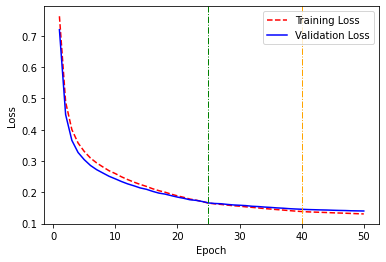

In [25]:
model = NeuralNet(hidden_activations= ['relu','relu'],learning_rate=0.003,min_batch_size=50,hidden_dims=(512,64))
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [26]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 96.28999999999999
Test accuracy 95.83


+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,500)    | 392.50K |
|  h_1   |   (500,250)    | 125.25K |
|  h_2   |    (250,60)    |  15.06K |
| output |    (60,10)     |  610.00 |
|        | Total # Params | 533.42K |
+--------+----------------+---------+


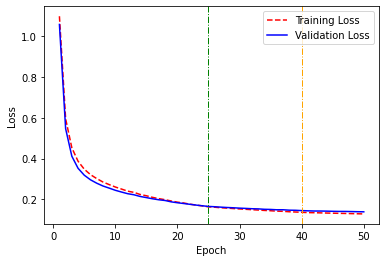

In [29]:
model = NeuralNet(hidden_activations= ['relu','relu','relu'],learning_rate=0.003,min_batch_size=80,hidden_dims=(500,250,60),n_hidden=3)
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [30]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 96.28999999999999
Test accuracy 95.99


+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,256)    | 200.96K |
|  h_1   |    (256,32)    |  8.22K  |
| output |    (32,10)     |  330.00 |
|        | Total # Params | 209.51K |
+--------+----------------+---------+


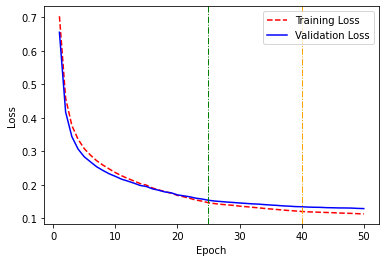

In [33]:
model = NeuralNet(hidden_activations= ['relu','relu'],learning_rate=0.004,min_batch_size=50,hidden_dims=(256,32),n_hidden=2)
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [34]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 96.44
Test accuracy 96.2


+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,512)    | 401.92K |
|  h_1   |    (512,64)    |  32.83K |
| output |    (64,10)     |  650.00 |
|        | Total # Params | 435.40K |
+--------+----------------+---------+


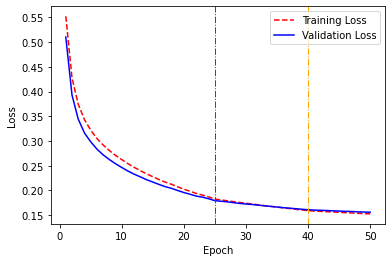

In [45]:
model = NeuralNet(hidden_activations= ['tanh','tanh'],learning_rate=0.007,min_batch_size=80,hidden_dims=(512,64))
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [46]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 95.89
Test accuracy 95.30999999999999


+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,256)    | 200.96K |
|  h_1   |    (256,32)    |  8.22K  |
| output |    (32,10)     |  330.00 |
|        | Total # Params | 209.51K |
+--------+----------------+---------+


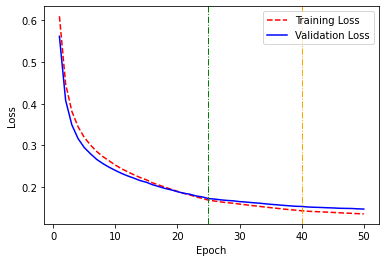

In [52]:
model = NeuralNet(hidden_activations= ['tanh','tanh'],learning_rate=0.015,min_batch_size=125,hidden_dims=(256,32),n_hidden=2)
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [53]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 95.94
Test accuracy 95.61


+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,500)    | 392.50K |
|  h_1   |   (500,200)    | 100.20K |
|  h_2   |    (200,50)    |  10.05K |
| output |    (50,10)     |  510.00 |
|        | Total # Params | 503.26K |
+--------+----------------+---------+


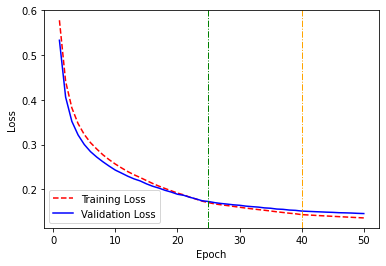

In [47]:
model = NeuralNet(hidden_activations= ['tanh','tanh','tanh'],learning_rate=0.009,min_batch_size=125,hidden_dims=(500,200,50),n_hidden=3)
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [48]:
print('Validation accuracy {}'.format(val_acc))
print('Test accuracy {}'.format(test_acc))

Validation accuracy 95.99
Test accuracy 95.67999999999999


# Best MLP Model

+--------+----------------+---------+
| Layer  |  Input Shape   | Param # |
+--------+----------------+---------+
| Input  |  (None, 784)   |    0    |
|  h_0   |   (784,256)    | 200.96K |
|  h_1   |    (256,32)    |  8.22K  |
| output |    (32,10)     |  330.00 |
|        | Total # Params | 209.51K |
+--------+----------------+---------+


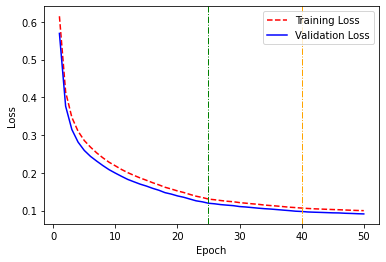

In [55]:
# Note : This model is trained for all 60,000 images = training + validation.
model = NeuralNet(hidden_activations= ['relu','relu'],learning_rate=0.004,min_batch_size=50,hidden_dims=(256,32),n_hidden=2)
val_acc, val_loss, test_acc, predicted_test = model.train() 

In [56]:
print('Best Model Test accuracy {}'.format(test_acc))

Best Model Test accuracy 96.56
